**About Dataset**
The data consists of 48x48 pixel grayscale images of faces.
The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

**Goal**

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [1]:
pip install tensorflow numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np

In [8]:
# importing
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [34]:
import tensorflow as tf
print(tf.__version__)
print(tf.__path__)


2.18.0
['c:\\Users\\PMLS\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\keras\\api\\_v2', 'c:\\Users\\PMLS\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\keras\\_tf_keras', 'c:\\Users\\PMLS\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\tensorflow', 'c:\\Users\\PMLS\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\tensorflow\\_api\\v2']


In [3]:
import sys
print(sys.executable)


c:\Users\PMLS\AppData\Local\Programs\Python\Python311\python.exe


In [4]:
# Directories
#train_dir = '/kaggle/input/fer2013/train'
#test_dir = '/kaggle/input/fer2013/test'
train_dir = r'C:\Users\PMLS\Downloads\FERDataset\train'
test_dir = r'C:\Users\PMLS\Downloads\FERDataset\test'


**Dataset Info**

In [5]:
# Function to get dataset information
def get_dataset_info(directory):
    data_info = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'png', 'jpeg')):  # Include common image extensions
                file_path = os.path.join(root, file)
                data_info.append({
                    "File Name": file,
                    "File Path": file_path,
                    "Subfolder": os.path.basename(root)
                })
    return pd.DataFrame(data_info)

# Get information
train_info = get_dataset_info(train_dir)
test_info = get_dataset_info(test_dir)

# Display the first few rows of train dataset information
print("Train Dataset Info:")
print(train_info.head())

# Display summary statistics
print("\nTrain Dataset Summary:")
print(train_info['Subfolder'].value_counts())

print("\nTest Dataset Info:")
print(test_info.head())

print("\nTest Dataset Summary:")
print(test_info['Subfolder'].value_counts())


Train Dataset Info:
               File Name                                          File Path  \
0  Training_10118481.jpg  C:\Users\PMLS\Downloads\FERDataset\train\angry...   
1  Training_10120469.jpg  C:\Users\PMLS\Downloads\FERDataset\train\angry...   
2  Training_10131352.jpg  C:\Users\PMLS\Downloads\FERDataset\train\angry...   
3  Training_10161559.jpg  C:\Users\PMLS\Downloads\FERDataset\train\angry...   
4   Training_1021836.jpg  C:\Users\PMLS\Downloads\FERDataset\train\angry...   

  Subfolder  
0     angry  
1     angry  
2     angry  
3     angry  
4     angry  

Train Dataset Summary:
Subfolder
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

Test Dataset Info:
                  File Name  \
0  PrivateTest_10131363.jpg   
1  PrivateTest_10304478.jpg   
2   PrivateTest_1054527.jpg   
3  PrivateTest_10590091.jpg   
4   PrivateTest_1109992.jpg   

                                   

**Sample Images**

Total images explored: 28709
Sample Image Info:
{'File Name': 'Training_10118481.jpg', 'Dimensions': (48, 48), 'Mode': 'L'}
{'File Name': 'Training_10120469.jpg', 'Dimensions': (48, 48), 'Mode': 'L'}
{'File Name': 'Training_10131352.jpg', 'Dimensions': (48, 48), 'Mode': 'L'}
{'File Name': 'Training_10161559.jpg', 'Dimensions': (48, 48), 'Mode': 'L'}
{'File Name': 'Training_1021836.jpg', 'Dimensions': (48, 48), 'Mode': 'L'}


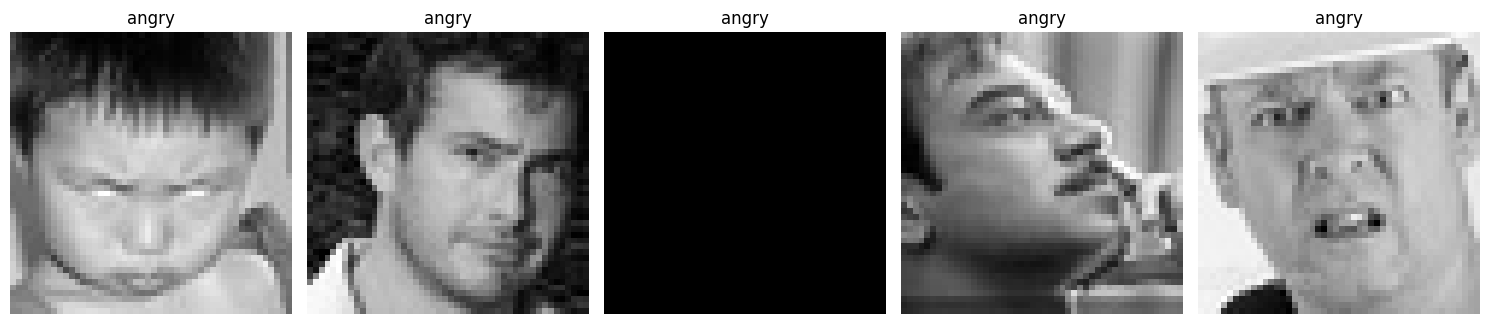

In [26]:

# Function to get image details
def explore_images(directory, num_images=5):
    image_details = []
    images_to_show = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'png', 'jpeg')):
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    image_details.append({
                        "File Name": file,
                        "Dimensions": img.size,  # (width, height)
                        "Mode": img.mode  # Color mode (e.g., RGB, L)
                    })
                    # Collect a few images to display
                    if len(images_to_show) < num_images:
                        images_to_show.append((img.copy(), os.path.basename(root)))
    
    return image_details, images_to_show

# Explore train images
image_info, sample_images = explore_images(train_dir)

# Print image details
print(f"Total images explored: {len(image_info)}")
print("Sample Image Info:")
for info in image_info[:5]:  # Print details for the first 5 images
    print(info)

# Display some images
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
for ax, (img, label) in zip(axes, sample_images):
    ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [16]:
# Parameters
img_height, img_width = 48, 48  
batch_size = 32
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]


**Data Augmentation , CNN Model Training**

In [23]:
# Parameters
img_height, img_width = 48, 48  # Assuming 48x48 images
batch_size = 32
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

# Verifying Class Indices
print("Class indices (label mapping):", train_generator.class_indices)

# Building the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(emotion_labels), activation='softmax')  # Output layer with 7 categories
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_CNN.keras', monitor='val_loss', save_best_only=True)

# Training the Model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the best model weights
print("Training completed. Best model weights saved in 'best_CNN.keras'.")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class indices (label mapping): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 128s 136ms/step - accuracy: 0.1954 - loss: 2.4135 - val_accuracy: 0.2931 - val_loss: 1.7536
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 116s 129ms/step - accuracy: 0.2562 - loss: 1.8110 - val_accuracy: 0.2878 - val_loss: 1.8238
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 102s 114ms/step - accuracy: 0.2917 - loss: 1.7495 - val_accuracy: 0.2905 - val_loss: 2.2707
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 110s 122ms/step - accuracy: 0.3163 - loss: 1.6944 - val_accuracy: 0.3943 - val_loss: 1.5483
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 132s 147ms/step - accuracy: 0.3360 - loss: 1.6505 - val_accuracy: 0.3558 - val_loss: 1.6228
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 103s 114ms/step - accuracy: 0.3589 - loss: 1.6175 - val_accuracy: 0.4380 - val_loss: 1.4511
Epo

In [27]:
# Step 1: Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size for MobileNet
IMG_SIZE = (224, 224)

# Data generators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate training and testing datasets
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',  # Convert grayscale to 3 channels for MobileNet
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**evaluating the model's performance**

225/225 ━━━━━━━━━━━━━━━━━━━━ 168s 745ms/step
Confusion Matrix:
[[ 398    0   29  185  146  140   60]
 [  60    0    3   23    8   11    6]
 [ 185    0  107  174  165  234  159]
 [ 111    0   15 1405  101   95   47]
 [ 140    0   30  202  628  179   54]
 [ 185    0   55  245  234  507   21]
 [  60    0   65   74   70   23  539]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.35      0.42      0.38       958
     Disgust       0.00      0.00      0.00       111
        Fear       0.35      0.10      0.16      1024
       Happy       0.61      0.79      0.69      1774
         Sad       0.46      0.51      0.49      1233
    Surprise       0.43      0.41      0.42      1247
     Neutral       0.61      0.65      0.63       831

    accuracy                           0.50      7178
   macro avg       0.40      0.41      0.39      7178
weighted avg       0.47      0.50      0.47      7178

F1 Score: 0.47
Recall: 0.50
Accuracy: 0.50


c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

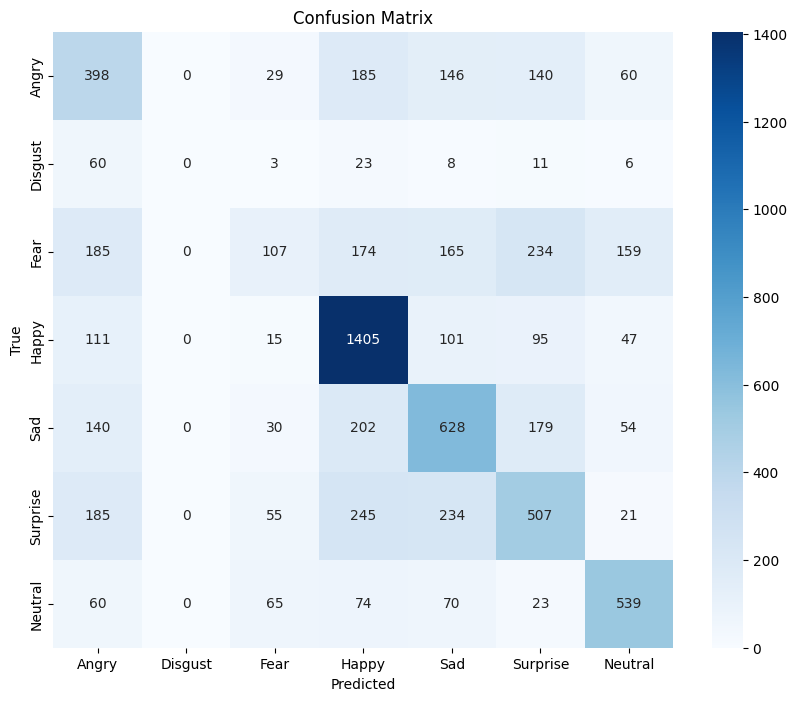

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the Model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Metrics Calculation
conf_matrix = confusion_matrix(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=emotion_labels))
print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Assuming the history object from model training
history = model.history  # Replace with your actual history variable




**Using Pre_trained Model . MobileNetv2 Fine-Tuning**
Preprocessing the Dataset

In [5]:
# Step 1: Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size for MobileNet
IMG_SIZE = (224, 224)

# Data generators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate training and testing datasets
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',  # Convert grayscale to 3 channels for MobileNet
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
# Step 2: Load MobileNet and customize
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load MobileNet with pre-trained weights
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Regularization
predictions = Dense(7, activation='softmax')(x)  # Output layer (7 classes)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)



In [10]:
# Step 3: Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Step 4: Training with early stopping and checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_mobilenet_weights.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=55,
    callbacks=[early_stop, checkpoint]
)

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 6: Save the final model
model.save('mobilenet_fer_model.keras')


c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2368 - loss: 1.9342

898/898 ━━━━━━━━━━━━━━━━━━━━ 1567s 2s/step - accuracy: 0.2369 - loss: 1.9341 - val_accuracy: 0.3862 - val_loss: 1.6225
Epoch 2/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.3267 - loss: 1.6909

898/898 ━━━━━━━━━━━━━━━━━━━━ 1051s 1s/step - accuracy: 0.3268 - loss: 1.6909 - val_accuracy: 0.4087 - val_loss: 1.5480
Epoch 3/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.3685 - loss: 1.6256

898/898 ━━━━━━━━━━━━━━━━━━━━ 1019s 1s/step - accuracy: 0.3685 - loss: 1.6256 - val_accuracy: 0.4340 - val_loss: 1.4930
Epoch 4/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3721 - loss: 1.6014

898/898 ━━━━━━━━━━━━━━━━━━━━ 1077s 1s/step - accuracy: 0.3721 - loss: 1.6014 - val_accuracy: 0.4376 - val_loss: 1.4723
Epoch 5/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.3887 - loss: 1.5812

898/898 ━━━━━━━━━━━━━━━━━━━━ 877s 977ms/step - accuracy: 0.3887 - loss: 1.5812 - val_accuracy: 0.4426 - val_loss: 1.4485
Epoch 6/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.4042 - loss: 1.5453

898/898 ━━━━━━━━━━━━━━━━━━━━ 968s 1s/step - accuracy: 0.4042 - loss: 1.5453 - val_accuracy: 0.4582 - val_loss: 1.4276
Epoch 7/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.4111 - loss: 1.5332

898/898 ━━━━━━━━━━━━━━━━━━━━ 1004s 1s/step - accuracy: 0.4111 - loss: 1.5332 - val_accuracy: 0.4572 - val_loss: 1.4165
Epoch 8/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.4138 - loss: 1.5175

898/898 ━━━━━━━━━━━━━━━━━━━━ 924s 1s/step - accuracy: 0.4138 - loss: 1.5175 - val_accuracy: 0.4707 - val_loss: 1.3921
Epoch 9/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.4217 - loss: 1.5036

898/898 ━━━━━━━━━━━━━━━━━━━━ 900s 1s/step - accuracy: 0.4217 - loss: 1.5036 - val_accuracy: 0.4707 - val_loss: 1.3843
Epoch 10/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.4285 - loss: 1.4975

898/898 ━━━━━━━━━━━━━━━━━━━━ 989s 1s/step - accuracy: 0.4285 - loss: 1.4975 - val_accuracy: 0.4664 - val_loss: 1.3789
Epoch 11/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4251 - loss: 1.4950

898/898 ━━━━━━━━━━━━━━━━━━━━ 1521s 2s/step - accuracy: 0.4251 - loss: 1.4950 - val_accuracy: 0.4766 - val_loss: 1.3656
Epoch 12/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.4261 - loss: 1.4923 

898/898 ━━━━━━━━━━━━━━━━━━━━ 31403s 35s/step - accuracy: 0.4261 - loss: 1.4923 - val_accuracy: 0.4823 - val_loss: 1.3590
Epoch 13/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 959s 1s/step - accuracy: 0.4377 - loss: 1.4740 - val_accuracy: 0.4758 - val_loss: 1.3618
Epoch 14/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.4396 - loss: 1.4663

898/898 ━━━━━━━━━━━━━━━━━━━━ 808s 900ms/step - accuracy: 0.4396 - loss: 1.4664 - val_accuracy: 0.4854 - val_loss: 1.3472
Epoch 15/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 915s 1s/step - accuracy: 0.4405 - loss: 1.4645 - val_accuracy: 0.4833 - val_loss: 1.3511
Epoch 16/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.4389 - loss: 1.4673

898/898 ━━━━━━━━━━━━━━━━━━━━ 888s 989ms/step - accuracy: 0.4389 - loss: 1.4673 - val_accuracy: 0.4882 - val_loss: 1.3375
Epoch 17/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.4426 - loss: 1.4544

898/898 ━━━━━━━━━━━━━━━━━━━━ 886s 987ms/step - accuracy: 0.4426 - loss: 1.4544 - val_accuracy: 0.4900 - val_loss: 1.3350
Epoch 18/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.4405 - loss: 1.4507

898/898 ━━━━━━━━━━━━━━━━━━━━ 883s 983ms/step - accuracy: 0.4405 - loss: 1.4507 - val_accuracy: 0.4955 - val_loss: 1.3301
Epoch 19/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4484 - loss: 1.4420

898/898 ━━━━━━━━━━━━━━━━━━━━ 5218s 6s/step - accuracy: 0.4484 - loss: 1.4420 - val_accuracy: 0.4922 - val_loss: 1.3277
Epoch 20/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 816s 908ms/step - accuracy: 0.4468 - loss: 1.4443 - val_accuracy: 0.4937 - val_loss: 1.3279
Epoch 21/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.4473 - loss: 1.4415

898/898 ━━━━━━━━━━━━━━━━━━━━ 810s 902ms/step - accuracy: 0.4473 - loss: 1.4415 - val_accuracy: 0.4958 - val_loss: 1.3243
Epoch 22/55
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.4524 - loss: 1.4329

898/898 ━━━━━━━━━━━━━━━━━━━━ 854s 951ms/step - accuracy: 0.4524 - loss: 1.4329 - val_accuracy: 0.4951 - val_loss: 1.3121
Epoch 23/55
519/898 ━━━━━━━━━━━━━━━━━━━━ 10:51 2s/step - accuracy: 0.4563 - loss: 1.4288

KeyboardInterrupt: 

Interupt the above cell due to lack of time, well saved the best weights below

In [13]:
model.save('interrupted_model.keras')
print("Model saved.")


Model saved.


*Evaluating the mobilenet Model on 22 epoch*

c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


225/225 ━━━━━━━━━━━━━━━━━━━━ 158s 695ms/step
Classification Report:
               precision    recall  f1-score   support

       angry     0.3494    0.4154    0.3796       958
     disgust     0.0000    0.0000    0.0000       111
        fear     0.3520    0.1045    0.1611      1024
       happy     0.6088    0.7920    0.6884      1774
     neutral     0.4645    0.5093    0.4859      1233
         sad     0.4264    0.4066    0.4163      1247
    surprise     0.6084    0.6486    0.6278       831

    accuracy                         0.4993      7178
   macro avg     0.4013    0.4109    0.3942      7178
weighted avg     0.4716    0.4993    0.4722      7178



c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

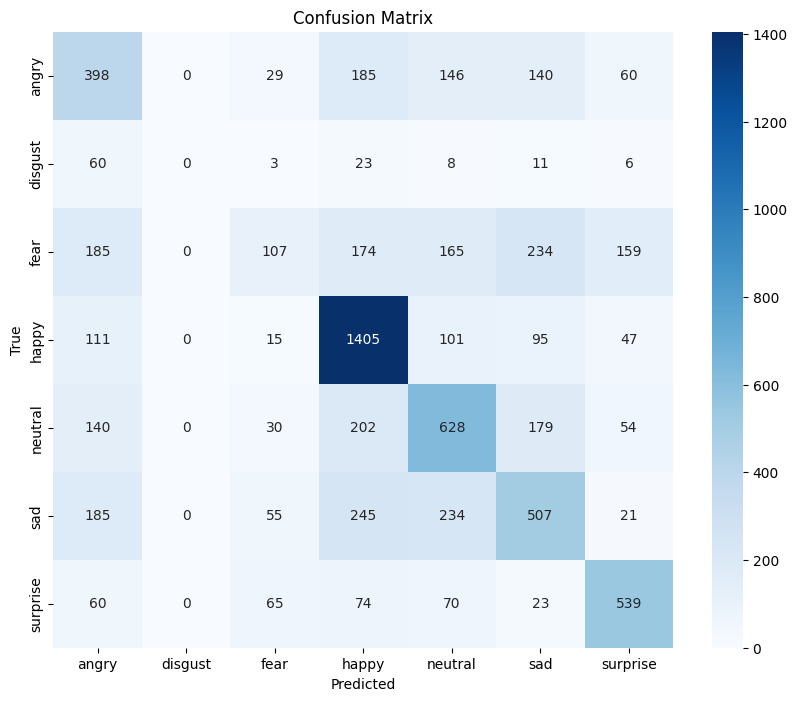

Accuracy: 49.93%
F1 Score: 47.22%
Recall: 49.93%
Precision: 47.16%


c:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Step 1: Reload the Model
from tensorflow.keras.models import load_model

model = load_model('interrupted_model.keras')

# Step 2: Make Predictions on Test Data
# Ensure test_generator is already defined and initialized
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Step 3: Compute Metrics
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4)
print("Classification Report:\n", report)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Additional Metrics (Optional)
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
precision = precision_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
